这次使用PyTorch的自动求导功能得到优化后的模型。

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

## generate Data

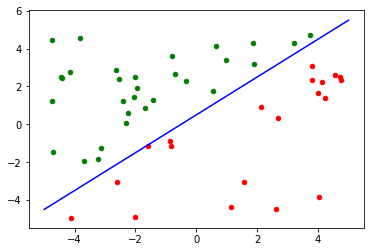

In [4]:
N = 50
features = (torch.rand(N, 2) - 0.5) * 10
labels = (features[:,0] - features[:,1] + 0.5 > 0).float()
labels[labels == 0] = -1
plt.figure

# positive samples
pos_samples = features[(labels>0).nonzero().squeeze()].numpy()
neg_samples = features[(labels<0).nonzero().squeeze()].numpy()
plt.scatter(pos_samples[:,0], pos_samples[:,1], 20, 'r')
plt.scatter(neg_samples[:,0], neg_samples[:,1], 20, 'g')
x1 = np.linspace(-5, 5, 100)
x2 = x1 + 0.5
plt.plot(x1, x2, 'b-')
plt.show()

第一种方法，不使用Torch中提供的optimizer，而只是利用了Torch提供的自动求导功能。设计类`Perceptron`继承自`nn.Module`，实现前向计算即可。Torch的自动求导会自动为我们实现bp。

In [50]:
from torch.autograd import Variable
import torch.nn as nn
class Perceptron(nn.Module):
    def __init__(self, dim_in):
        super(Perceptron, self).__init__()
        self.W = nn.Parameter(torch.zeros(dim_in))
        self.b = nn.Parameter(torch.zeros(1))
    def forward(self, x, target):
        """override `forward` method
        x: input data
        target: labels"""
        score = x.mm(self.W.unsqueeze(1))
        score += self.b.unsqueeze(1).expand_as(score).squeeze()
        pred = (score > 0).float().squeeze()
        pred[pred == 0] = -1
        err_index = (pred != target).data.nonzero().squeeze()
        err_cnt = torch.numel(err_index)
        if err_cnt == 0:
            return pred, err_cnt, Variable(torch.zeros(1))
        err_y = target[err_index]
        score = score[err_index]
        loss = torch.sum(-err_y * score)
        return pred, err_cnt, loss

让我们测试一下，是否得到了参数的梯度。

In [51]:
model = Perceptron(2)
features_var, labels_var = Variable(features), Variable(labels)
pred, err_cnt, loss = model.forward(features_var, labels_var)
loss.backward()
print model.W.grad.data
print model.b.grad.data
del model


-36.1368
 12.3401
[torch.FloatTensor of size 2]


-20
[torch.FloatTensor of size 1]



让我们使用下面的方法手动更新参数。
```
for data, target in datasets:
    model.zero_grad()
    loss = model(data, target)
    loss.backward()
    for param in model.parameters:
        param.data -= lr * param.grad
```

In [57]:
model = Perceptron(2)
lr = 0.1
for i in xrange(20):
    model.zero_grad()
    pred, err_cnt, loss = model(features_var, labels_var)
    print 'iter {}: err count = {}, loss = {:.6f}'.format(i, err_cnt, loss.data[0])
    if err_cnt == 0:
        break
    loss.backward()
    model.W.data -= lr * model.W.grad.data
    model.b.data -= lr * model.b.grad.data

iter 0: err count = 20, loss = 0.000000
iter 1: err count = 10, loss = 42.099030
iter 2: err count = 10, loss = 31.894926
iter 3: err count = 10, loss = 51.720947
iter 4: err count = 2, loss = 1.523977
iter 5: err count = 0, loss = 0.000000


使用下面的方法来可视化训练结果。

In [58]:
def show_result(trainned_model):
    W, b = trainned_model.W.data, trainned_model.b.data
    plt.scatter(pos_samples[:,0], pos_samples[:,1], 20, 'r')
    plt.scatter(neg_samples[:,0], neg_samples[:,1], 20, 'g')
    x1 = np.linspace(-5, 5, 100)
    x2 = -W[0]/W[1]*x1 - b[0] / W[1]
    plt.plot(x1, x2, 'b-')
    plt.show()

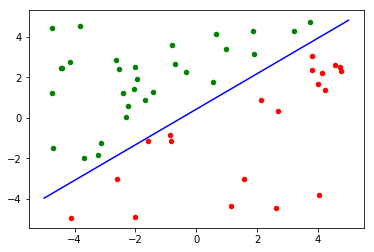

In [59]:
show_result(model)
del model

接下来，更进一步，我们直接使用Torch提供的SGD优化方法进行参数的更新。我们只需要将要更新的参数传入类`SGD`的构造函数即可。为什么`model.parameters()`方法就能够获得`model`中所有参数的迭代器呢？这是因为`W`和`b`都被我们声明为`Parameter`类型。当`nn.Module`中声明`Variable`类型的成员变量时，会将其自动加入到参数列表中。这些是Torch在背后默默为我们做的。

In [60]:
import torch.optim as optim
model = Perceptron(2)
optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum=0.9)
for i in xrange(20):
    optimizer.zero_grad()
    pred, err_cnt, loss = model(features_var, labels_var)
    print 'iter {}: err count = {}, loss = {:.6f}'.format(i, err_cnt, loss.data[0])
    if err_cnt == 0:
        break
    loss.backward()
    optimizer.step()

iter 0: err count = 20, loss = 0.000000
iter 1: err count = 10, loss = 42.099030
iter 2: err count = 0, loss = 0.000000


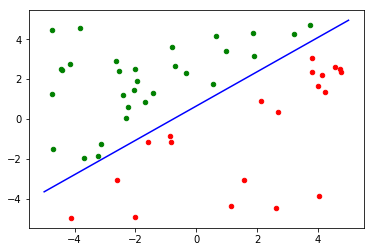

In [61]:
show_result(model)